## generating genotypes from OpenArray (hybridization array) data

In [1]:
import allel
import h5py
import ingenos
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.metrics import confusion_matrix
%matplotlib inline

##### set base directory

In [2]:
base = "/afs/crc.nd.edu/group/BesanskyNGS/data05/comp_karyo/data/open_array"

##### read in data

In [3]:
results = pd.read_csv(base + "/an_gambiae_results/final_agam_wide.csv",
                        na_values = -9)

results.set_index("SampleID", inplace=True)

results = results.T

results.head()

SampleID,BF0600001,BF0600005,BF0600012,BF0600024,BF0600028,BF0600035,BF0600042,BF0600045,BF0600051,BF0600072,...,BF0605588,BF0605589,BF0605595,BF0605596,BF0605598,BF0605602,BF0605606,BF0605620,BF0605624,BF0605647
2L:20546192_G_A,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0
2L:20731296_A_T,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
2L:20816241_G_T,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
2L:21590819_G_A,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
2L:21687929_C_G,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0


##### add species information to the raw data

In [4]:
md = pd.read_excel(
    base + "/metadata/AGAM_All_10_Plates_updated_040820.xls")

md = md[["tubeID","taxon","j","b","c","d","u","2La","ovaries",
         "notes1","Reader", "Corrected", "Uncertain"]]

md.columns = ["ID","species","j_karyo","b_karyo","c_karyo",
              "d_karyo","u_karyo","a_karyo",
             "ovaries","notes","reader", "Corrected", "Uncertain"]

md.sort_values("ID", inplace=True)

##### drop the specimens with ambiguous metadata

In [5]:
results.drop(["BF0600157", "BF0601559", "BF0601669"], axis=1, inplace=True)

md = md.loc[md["Uncertain"] == "no"]

In [6]:
columns = results.T.reset_index().columns

results = pd.merge(results.T.reset_index(), md, 
                   left_on = "SampleID", right_on = "ID")\
[np.append(columns, "species")].set_index(["SampleID", "species"])

##### associate tag SNPs with inversions

In [7]:
results = results.T

results["chrom"] = results.reset_index()["index"].str.split(
    ":", expand=True)[0].values

results["pos"] =\
results.reset_index()["index"].str.split(
    ":", expand=True)[1].str.split("_", expand=True)[0].map(int).values

In [8]:
targets = pd.read_csv(base + "/Besansky_lab_candidate_SNPs.tsv", sep="\t")

cu_new = pd.read_csv(base + "/2Rc_cu_new_targets.txt", 
                     sep="\t")

cu_new["label"] = pd.Series(["cu","cu"])

cu_new.drop(["REF","ALT"], axis=1, inplace=True)

cu_new.columns = ["chrom","position","label"]

targets = pd.concat([targets, cu_new], sort=True)

In [9]:
for _, row in targets.iterrows():
    
    position = row["position"]
    label = row["label"]
    
    results.loc[results["pos"] == position, "label"] = label
    
results.loc[results["pos"] == 30735706, "label"] = "c"

results.set_index(["label","pos"], inplace=True)

results.drop(["chrom"], axis=1, level=0, inplace=True)

results = results.T

results.head()

label                    a                                               \
pos               20546192 20731296 20816241 21590819 21687929 40791634   
SampleID  species                                                         
BF0600001 M            2.0      2.0      2.0      2.0      2.0      2.0   
BF0600005 M            2.0      2.0      2.0      2.0      2.0      2.0   
BF0600012 M            2.0      2.0      2.0      2.0      2.0      2.0   
BF0600024 M            2.0      2.0      2.0      2.0      2.0      2.0   
BF0600028 M            2.0      2.0      2.0      2.0      2.0      2.0   

label                                      j           ...        d        u  \
pos               40854796 41966114 15740463 15740978  ... 32882145 33291225   
SampleID  species                                      ...                     
BF0600001 M            2.0      2.0      0.0      0.0  ...      0.0      2.0   
BF0600005 M            2.0      2.0      0.0      0.0  ...      0.0      0.0   
BF0600012 M            2.0      2.0      0.0      0.0  ...      0.0      0.0   
BF0600024 M            2.0      2.0      0.0      0.0  ...      0.0      1.0   
BF0600028 M            2.0      2.0      0.0      0.0  ...      0.0      0.0   

label                                               d                    \
pos               33530416 33776367 34610188 35926470 36201603 36280038   
SampleID  species                                                         
BF0600001 M            NaN      1.0      2.0      0.0      0.0      0.0   
BF0600005 M            0.0      0.0      0.0      0.0      0.0      0.0   
BF0600012 M            0.0      0.0      0.0      0.0      0.0      0.0   
BF0600024 M            0.0      1.0      0.0      0.0      0.0      0.0   
BF0600028 M            0.0      1.0      1.0      0.0      0.0      0.0   

label                                
pos               36717402 38797590  
SampleID  species                    
BF0600001 M            0.0      0.0  
BF0600005 M            0.0      0.0  
BF0600012 M            0.0      0.0  
BF0600024 M            0.0      0.0  
BF0600028 M            0.0      1.0  

[5 rows x 57 columns]

##### drop unused partitions

In [10]:
results.drop(["cu","c"], level=0, axis=1, inplace=True)
results.columns = results.columns.remove_unused_levels()
results.index = results.index.remove_unused_levels()

##### examine the data quality. first, look at the call rates per SNP

In [11]:
inversions = ["a", "j", "b", "c_col", "c_gam", "d", "u"]

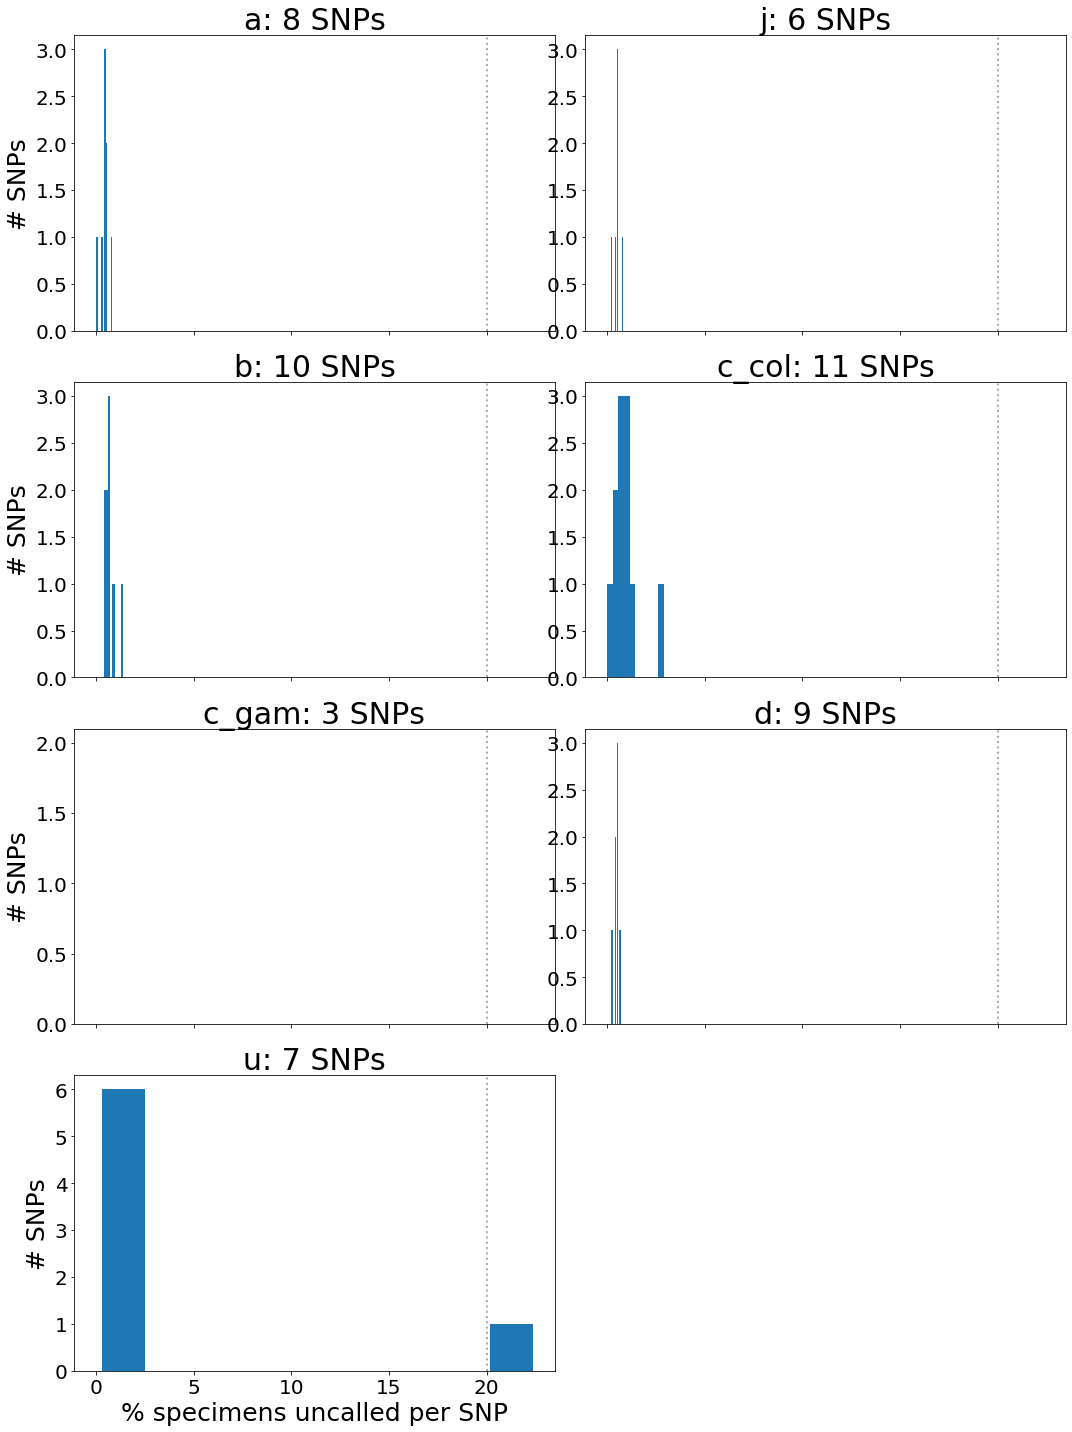

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, figsize = (15, 20))

for i, ax in enumerate(axes.flatten()):
    
    if i == 7:
                
        ax.axis('off')
        
    else:
        
        inversion = inversions[i]
    
        if inversion == "c_col":

            chunk = results.loc[(slice(None), "M"), inversion]

        elif inversion == "c_gam":

            chunk = results.loc[(slice(None), "S"), inversion]

        else:

            chunk = results.loc[:,inversion]

        n_specs = chunk.shape[0]
        n_snps = chunk.shape[1]

        ax.hist( (np.sum(chunk.isnull(), axis=0) / n_specs) * 100)
        ax.axvline(x=20, linewidth=2, color="darkgrey", linestyle=":")

        ax.set_title("{inversion}: {num} SNPs".format(
            inversion = inversion, num = n_snps), fontsize=30)
        ax.tick_params(labelsize=20)

        if i % 2 == 0:

                ax.set_ylabel("# SNPs", fontsize=25)

        if i == 6 or i == 7:

                ax.set_xlabel("% specimens uncalled per SNP", fontsize=25)
            
plt.tight_layout()
            
outString = ingenos.make_date_stamp(
    base + "/results/missingness_by_inversion")

#plt.savefig(outString);

In [13]:
for inversion in inversions:
    
    if inversion == "c_col":
        
        chunk = results.loc[(slice(None), "M"), inversion]
        
    elif inversion == "c_gam":
        
        chunk = results.loc[(slice(None), "S"), inversion]
        
    elif inversion is np.nan:
        
        continue
        
    else:
        
        chunk = results.loc[:, inversion]
        
    print(inversion, "\n")
    print("minimum call rate: ", 1 - chunk.isnull().mean().max())
    print("maximum call rate: ", 1 - chunk.isnull().mean().min(), "\n")

a 

minimum call rate:  0.9916405433646813
maximum call rate:  1.0 

j 

minimum call rate:  0.9916405433646813
maximum call rate:  0.9979101358411703 

b 

minimum call rate:  0.9864158829676071
maximum call rate:  0.9958202716823407 

c_col 

minimum call rate:  0.9710982658959537
maximum call rate:  1.0 

c_gam 

minimum call rate:  0.997716894977169
maximum call rate:  1.0 

d 

minimum call rate:  0.9926854754440961
maximum call rate:  0.9979101358411703 

u 

minimum call rate:  0.7763845350052246
maximum call rate:  0.9968652037617555 



In [14]:
missing_df = pd.DataFrame(columns = ["label", "n_called"])

for inversion in inversions:
    
    if inversion == "c_col":

        chunk = results.loc[(slice(None), "M"), inversion]

    elif inversion == "c_gam":

        chunk = results.loc[(slice(None), "S"), inversion]

    else:

        chunk = results.loc[:,inversion]

    n_specs = chunk.shape[0]
    n_snps = chunk.shape[1]
    
    missing_df = missing_df.append(pd.DataFrame({"label" : [inversion] * n_snps,
                 "n_called" : ((1-(np.sum(chunk.isnull(), axis=0) / n_specs)) * 100).values}))


In [15]:
missing_df["label"].value_counts()

c_col    11
b        10
d         9
a         8
u         7
j         6
c_gam     3
Name: label, dtype: int64

In [16]:
label_positions = {"a" : 4,
                  "b" : 19,
                  "c_col" : 29.5,
                  "c_gam" : 36.5,
                  "d" : 47.5,
                  "j" : 11,
                  "u" : 40}

tick_list = list(missing_df.reset_index().drop_duplicates(subset="label").index)

tick_list.append(len(missing_df))

tick_list

[0, 8, 14, 24, 35, 38, 47, 54]

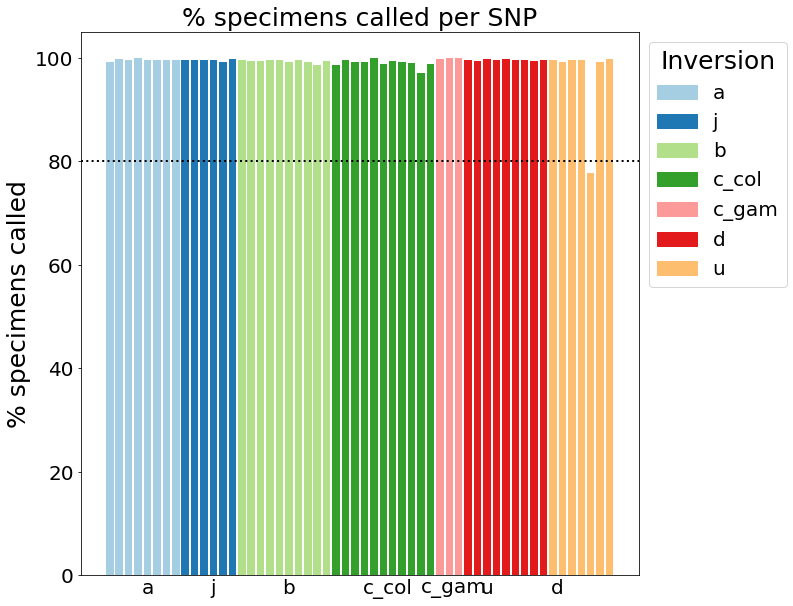

In [17]:
colors_dict = {value : plt.cm.Paired.colors[inversions.index(value)]\
 for value in missing_df["label"].unique()}

fig, ax = plt.subplots(figsize = (10, 10))

ax.bar(x = range(len(missing_df)), 
               height = missing_df["n_called"], 
       color=missing_df["label"].apply(lambda x: colors_dict[x]))
    
ax.tick_params(axis="x", which="both", length=0)
ax.set_xticks(list(label_positions.values()))
ax.set_xticklabels(list(label_positions.keys()))

ax.set_ylabel("% specimens called", fontsize=25)

ax.tick_params(labelsize=20)

color_handles = list()

for inversion in (colors_dict.keys()):
    patch = matplotlib.patches.Patch(color=colors_dict[inversion], label=inversion)
    color_handles.append(patch)

legend = ax.legend(handles = color_handles, bbox_to_anchor=(1, 1), title="Inversion", 
                   fontsize=20)
legend.get_title().set_fontsize(25)

ax.axhline(y=80, linewidth=2, color="black", linestyle=":")

ax.set_title("% specimens called per SNP", fontsize=25)

outString = ingenos.make_date_stamp(base + "/results/missingness_by_inversion")

#plt.savefig(outString, bbox_inches="tight");

In [18]:
1 - results.loc[:, "u"].isnull().mean()

pos
31516240    0.995820
31562705    0.991641
32295931    0.994775
33291225    0.994775
33530416    0.776385
33776367    0.991641
34610188    0.996865
dtype: float64

##### drop the SNP with a call rate below 80%

In [19]:
results.drop(("u", 33530416), axis=1, inplace=True)

##### now, look at specimen missingness and drop specimens with poor call rates

In [20]:
specimen_calls = pd.read_excel(
    base + "/an_gambiae_results/agam_callrates.xlsx",
                          sheet_name = "Sample Call Rate")

In [21]:
sample_missingness =\
pd.concat([pd.DataFrame(results.loc[
    (slice(None), "M"), 
    ["a","j","b","c_col","u","d"]].isnull().mean(axis=1)),
          pd.DataFrame(results.loc[
              (slice(None), "S"), 
              ["a","j","b","c_gam","u","d"]].isnull().mean(axis=1))])

sample_missingness.columns = ["null_rate"]

In [22]:
sample_missingness.head()

,,null_rate
SampleID,species,
BF0600001,M,0.00
BF0600005,M,0.00
BF0600012,M,0.00
BF0600024,M,0.02
BF0600028,M,0.00


In [23]:
1 - sample_missingness.max()

null_rate    0.16
dtype: float64

In [24]:
1 - sample_missingness.min()

null_rate    1.0
dtype: float64

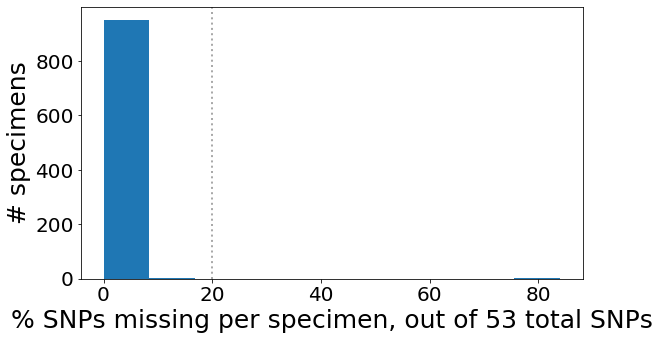

In [25]:
fig, ax = plt.subplots(figsize = (9, 5))

ax.hist( sample_missingness["null_rate"] *100, bins=10)
ax.axvline(x=20, linewidth=2, color="darkgrey", linestyle=":")
ax.set_xlabel("% SNPs missing per specimen, out of 53 total SNPs", fontsize=25)
ax.set_ylabel("# specimens", fontsize=25)
ax.tick_params(labelsize=20)

outString = ingenos.make_date_stamp(
    base + "/results/missingness_by_specimen")

#plt.savefig(outString, bbox_inches="tight");

In [26]:
sample_missingness.reset_index(inplace=True)

to_drop = sample_missingness.loc[sample_missingness["null_rate"] > 0.2, "SampleID"].values

to_drop

array(['BF0603488', 'BF0603493', 'BF0605404', 'BF0605526'], dtype=object)

In [27]:
results.drop(to_drop, axis=0, inplace=True)

results.shape

(953, 53)

In [28]:
md = md.loc[(~md["ID"].isin(to_drop)), :]

md.shape

(953, 13)

##### generate inversion genotypes: calculate the mean number of alternate alleles across all tag SNPs in a given inversion for a particular specimen

In [29]:
columns = [name + "_mean" for name in results.columns.levels[0]]

columns.extend([name + "_called" for name in results.columns.levels[0]])

averaged = pd.DataFrame(index = results.index, columns = columns)

inversions = results.columns.levels[0]

In [30]:
for inversion in inversions:
    
    chunk = results[inversion]
    
    for index, row in chunk.iterrows():
        
        averaged.loc[index, inversion + "_mean"] = np.mean(row)
        averaged.loc[index, inversion + "_called"] =\
        1 - np.mean(row.isnull())
        
averaged.head()

,,a_mean,j_mean,b_mean,c_col_mean,c_gam_mean,u_mean,d_mean,a_called,j_called,b_called,c_col_called,c_gam_called,u_called,d_called
SampleID,species,,,,,,,,,,,,,,
BF0600001,M,2,0,0.9,0.181818,0.333333,1.16667,0,1,1,1,1,1,1,1
BF0600005,M,2,0,1,0.181818,0.666667,0,0,1,1,1,1,1,1,1
BF0600012,M,2,0,0.8,0.181818,0.666667,0,0,1,1,1,1,1,1,1
BF0600024,M,2,0,0.8,0.0909091,0.333333,0.833333,0,1,0.833333,1,1,1,1,1
BF0600028,M,2,0,0.9,1.18182,0.666667,0.333333,0.111111,1,1,1,1,1,1,1


##### assign karyotypes based on the mean number of alternate alleles

In [31]:
for column in inversions:
    
    new_name = re.sub("_mean", "", column) + "_assigned"
    
    karyos = []
    
    for value in averaged[column + "_mean"].values:
        
        if value <= (2/3):
            
            karyos.append(0)
            
        elif value > (2/3) and value <= (4/3):
            
            karyos.append(1)
            
        else:
            
            karyos.append(2)
            
    averaged[new_name] = karyos

##### merge with cytogenetic data

In [32]:
averaged.reset_index(inplace=True)

np.append(averaged.columns, ["a_karyo","j_karyo","b_karyo","c_karyo",
                             "d_karyo","u_karyo"])

merged = pd.merge(averaged, md, left_on="SampleID", right_on="ID")

merged.rename(columns = {"species_x" : "species"}, inplace=True)

merged = merged[np.append(averaged.columns, ["a_karyo","j_karyo",
                                             "b_karyo","c_karyo",
                                             "d_karyo","u_karyo"])]

merged.rename(columns = {"a_karyo" : "a_cyto",
                        "j_karyo" : "j_cyto",
                        "b_karyo" : "b_cyto",
                        "c_karyo" : "c_cyto",
                        "d_karyo" : "d_cyto",
                        "u_karyo" : "u_cyto"}, inplace=True)

##### save this file to the desired location

##### export the SNP list to the desired location, accessing it with this syntax: results.T.reset_index()[["label", "pos"]]